# 계층적 군집 (2)

kaggle customer 데이터 셋 적용

## #01. 패키지

모델 : scipy.cluster.AgglomerativeClustering

거리계산 : scipy.cluster.hierarchy.linkage

시각화 : scipy.cluster.hierarchy.dendrogram

평가 : sklearn.metrics.silhouette_score , silhouette_samples, yellowbrick.cluster.KElbowVisualizer

In [13]:
import sys
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from pandas import read_excel, DataFrame

# sklearn은 AgglomerativeClustering() 함수를 제공
from sklearn.cluster import AgglomerativeClustering

# 표준화
from sklearn.preprocessing import StandardScaler

## #02. 실습 데이터

In [23]:
origin = read_excel("https://data.hossam.kr/G02/customer.xlsx")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   고객ID    200 non-null    int64 
 1   성별      200 non-null    object
 2   나이      200 non-null    int64 
 3   연수입     200 non-null    int64 
 4   지출점수    200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


,고객ID,성별,나이,연수입,지출점수
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


> 연수입, 지출점수를 기준으로 군집화 진행

## #03. 데이터 전처리

### 1. 필요한 변수만 추출

In [24]:
origin.columns

Index(['고객ID', '성별', '나이', '연수입', '지출점수'], dtype='object')

In [25]:
# X = origin.filter(['연수입', '지출점수'])

X = origin.filter(['나이', '연수입', '지출점수'])
X.head()

,나이,연수입,지출점수
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


### 2. 데이터 표준화

In [26]:
scaler = StandardScaler()
'''
fit_transform은 fit, transform을 결합한 형태
학습과 예측치 산정을 동시에 수행해 학습 데이터를 받을 수 없음
학습 결과를 재사용할 경우 transform() 함수를 사용
fit : 학습을 통해 DF 내의 최소/최대값 계산
transform : 각 열의 값을 해당 열의 최대/최소값 사이의 범위로 변환한 새로운 데이터 배열
'''
n_data = scaler.fit_transform(X)
# n_data[:5]
ndf = DataFrame(n_data, columns=X.columns)
ndf.head()

,나이,연수입,지출점수
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


In [27]:
origin['성별'].value_counts()

성별
Female    112
Male       88
Name: count, dtype: int64

In [28]:
ndf['성별'] = origin['성별'].map({'Male':0, 'Female':1})
ndf

,나이,연수입,지출점수,성별
0,-1.424569,-1.738999,-0.434801,0
1,-1.281035,-1.738999,1.195704,0
2,-1.352802,-1.700830,-1.715913,1
3,-1.137502,-1.700830,1.040418,1
4,-0.563369,-1.662660,-0.395980,1
...,...,...,...,...
195,-0.276302,2.268791,1.118061,1
196,0.441365,2.497807,-0.861839,1
197,-0.491602,2.497807,0.923953,0
198,-0.491602,2.917671,-1.250054,0


### 3. 데이터 분포 확인

In [29]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

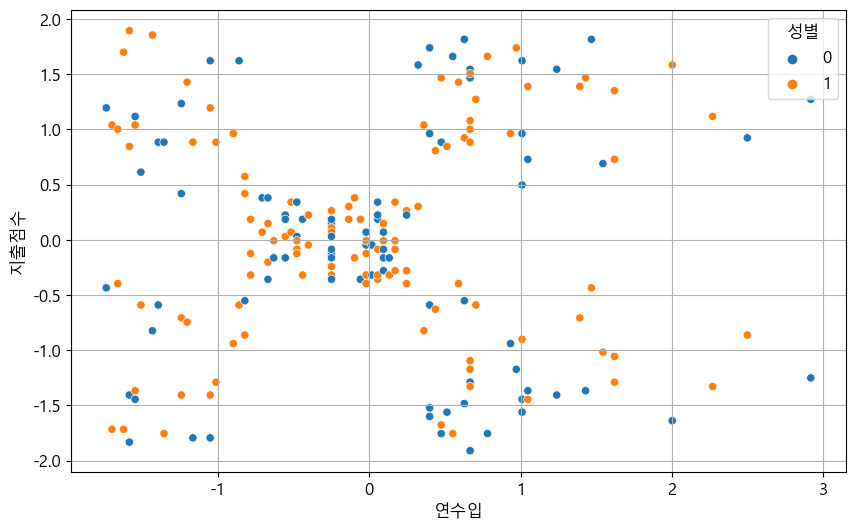

In [30]:
plt.figure(figsize=(10,6))
# sb.scatterplot(x=n_data[:,0], y=n_data[:,1])

sb.scatterplot(data=ndf, x='연수입', y='지출점수', hue='성별')
plt.grid()
plt.show()
plt.close()

## #04. 계층 군집 수행

### 1. scipy 패키지

scipy는 모델 생성/시각화 과정이 반자동이지만 sklearn은 수동으로 설정(공식으로 판단할 것)

- linkage : 거리 측정 방법 지정
- 기본 값 : ward
- 그 외 값 :  ‘ward’, ‘complete’, ‘average’, ‘single’

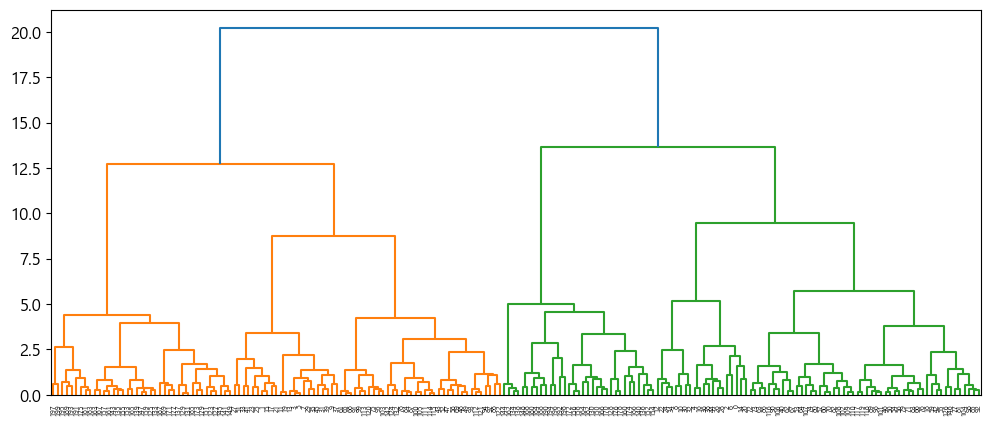

In [31]:
# lnk = linkage(n_data, method="ward")    #sklearn의 기본 method는 ward

lnk = linkage(ndf, method="ward")
plt.figure(figsize=(12,5))
dendrogram(lnk, show_leaf_counts=True)
plt.show()
plt.close()

### 2. sklearn 패키지

n_clusters : 찾아야 할 클러스터 수(earlystopping과 유사)

affinity : 클러스터 간 거리 측정 방법(euclidean, cityblock, manhattan, cosine)

linkage : ward(기본값), complete, average, single

compute_distances : 노드간의 거리 계산값을 저장할지 여부(시각화를 위해서는 True를 필수 적용)

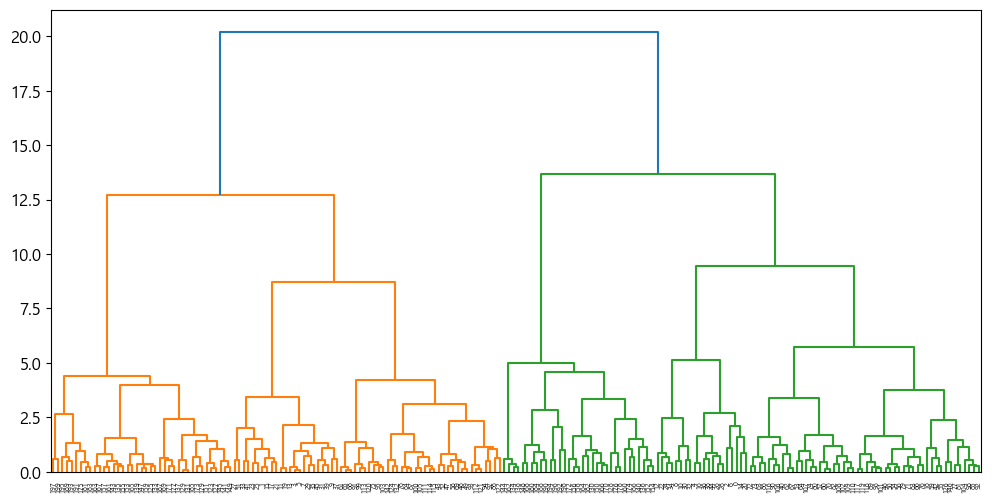

In [32]:
# 모델 객체 생성
ac = AgglomerativeClustering(n_clusters=5,  # 찾아야 할 클러스터 수(earlystopping과 유사)
                             metric='euclidean',  # 클러스터 간 거리 측정 방법
                             linkage='ward',    # 거리측정 방법
                             compute_distances=True #시각화를 위하 반드시 필요
                             )
# clustering = ac.fit(n_data) #학습

clustering = ac.fit(ndf) #학습
# print(clustering.labels_)   #학습결과 확인

# scipy는 아래의 과정을 자동으로 수행, sklearn은 수동으로 설정(공식으로 판단할 것)
counts = np.zeros(clustering.children_.shape[0])    #zeros 모든 원소가 0인 요소
n_samples = len(clustering.labels_)

# 자식 노드를 반복하면서 점을 찍어준다(자식이 몇개 있는지 확인하는 과정)
for i, merge in enumerate(clustering.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# 자식 노드의 수를 저장하는 배열
linkage_matrix = np.column_stack(
    [clustering.children_, clustering.distances_, counts]
).astype(float)

# plt를 설정하지 않으면 쓸데 없는 값도 함께 추출됨
# dendrogram(linkage_matrix)

plt.figure(figsize=(12,6))
dendrogram(linkage_matrix)
plt.show()
plt.close()

#### 군집수를 5로 제한했을 경우 분류 결과값

In [ ]:
clustering.labels_

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0], dtype=int64)

#### 분류 결과를 DF과 결합

In [35]:
origin['labels'] = clustering.labels_
origin.head()

,고객ID,성별,나이,연수입,지출점수,labels
0,1,Male,19,15,39,4
1,2,Male,21,15,81,0
2,3,Female,20,16,6,4
3,4,Female,23,16,77,0
4,5,Female,31,17,40,4


> 군집(label)을 포함한 DF 생성

labels를 hue로 잡고 진행하면 군집의 분류 결과를 알 수 있음

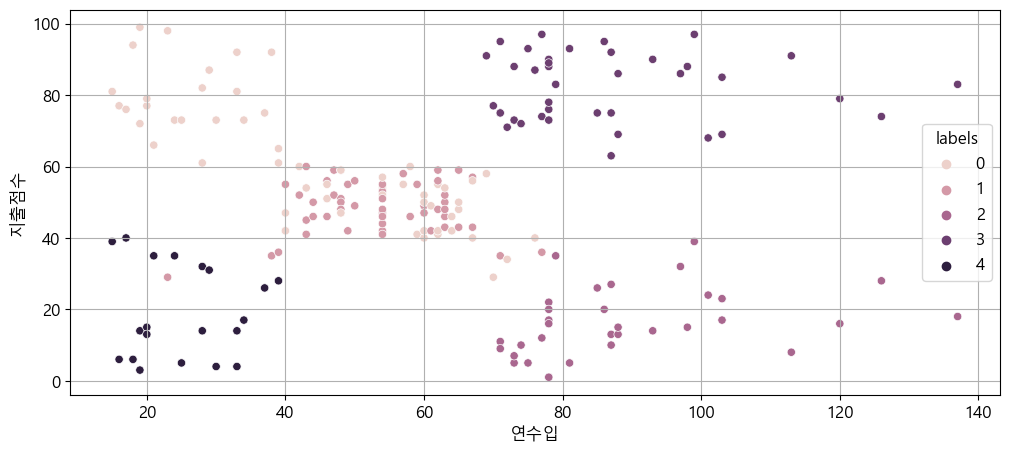

In [36]:
plt.figure(figsize=(12,5))
# #sb.scatterplot(x=n_data[, 0], y=n_data[, 1])
sb.scatterplot(data=origin, x='연수입', y='지출점수', hue='labels')
plt.grid()
plt.show()
plt.close()